# 1. Dataset Analysis

Dataset url: https://www.kaggle.com/datasets/googleai/pfam-seed-random-split

I have locally saved the raw data in the random_split/ it is partitioned into the three folds as per the initial dataset.

Definitions:
* Sequence: These are the Amino Acid sequences for each domain, which is a sub part of a protein. There are around 20 common amino acids and 4 uncommon ones.
* family_id/ family_accession: Labels for the model, containing the english words for the family and the Pfam ID.
* aligned_sequence: It's a sequence from the multiple sequence alignment - with gaps retained. 
* Sequence name: This is the name given to the sequence, form: "$uniprotaccessionid/$startindex-$end_index"

Reading this article on pfam and aligned sequences for context: https://academic.oup.com/nar/article/26/1/320/2379329
* pfam was established in 1998 was created as an organised database for protein domain families.

Dictionary:
* Domain: The structural and functional units of a protein, a proteins functionality come from their domains. A relatively (to the number of protein) low number of domains are used in a large # of proteins. Examples; solenoid, alpha alpha barrel, 3 layer sandwich (my personal favouritely named).

* Seed alignment - is a manually verified multiple alignment of a representative set of sequences, here's an example that made sense to me 
    * Example of a typical pfam entry, this is the SH2 family or PF00017
    * Dots and dashes represent identical and deleted amino acids, respectively


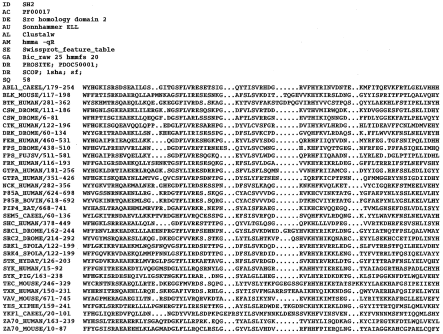

In [1]:
from IPython.display import Image

Image(filename='images/msa_example.gif', width=500, height=500) 

I have created a DatasetExplorer class which takes the three folds as inputs, as well as config for the various plots and displays.

Continuing work in this area, I would break this class down into subclasses for different areas of data exploration - e.g. a class specifically for family analysis, MSAs, one for sequences etc.

Looking at the data below, we can see there is 1m rows in train and approximately 100k in val/test.

In [3]:
import src.data.load_data as ld
import src.analysis.exploration as exp
import torch
import os

# params - would store in central config store but kept visible for ease of reading
num_gpus = torch.cuda.device_count()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
raw_data_path = "random_split/"
visualise_top_n_families = 10

loader = ld.DataLoader()
train_df, val_df, test_df = loader.load_all_three_dfs(raw_data_path)

explorer = exp.PfamExplorer(train_df, val_df, test_df, top_n_families=visualise_top_n_families)

explorer.print_n_rows_all_folds()


Number of rows: 1086741 for fold: train
Number of rows: 126171 for fold: val
Number of rows: 126171 for fold: test


The target variable is the family_accession or family_id which are equivalents.

Immediately we can see there are a large number of classes, with nearly 18000 unique families in train. Some of the families have a very large number of rows, others have very few. 

Something that we should be wary of in our analysis stage of our model is considering how the model does across families.

There are 4858 families in train that are not in val or test, I'm going to remove these as it doesn't make sense to train our model on classes that aren't going to appear.

In [4]:
explorer.family_summary_text()

There are 17929 unique families in train
There are 13071 unique families in val
There are 13071 unique families in test
There are 0 new families in test / val vs train
Number of rows per family:
count   17929.000
mean       60.614
std       115.623
min         1.000
25%         8.000
50%        22.000
75%        65.000
max      3637.000
Name: family_accession, dtype: float64





In [5]:
import src.processor as p

train_df = p.families_in_train_not_needed(train_df, val_df, test_df)
print("Remaining train size: " + str(train_df.shape[0]))

Number of families removed: 4858
Remaining train size: 1064950


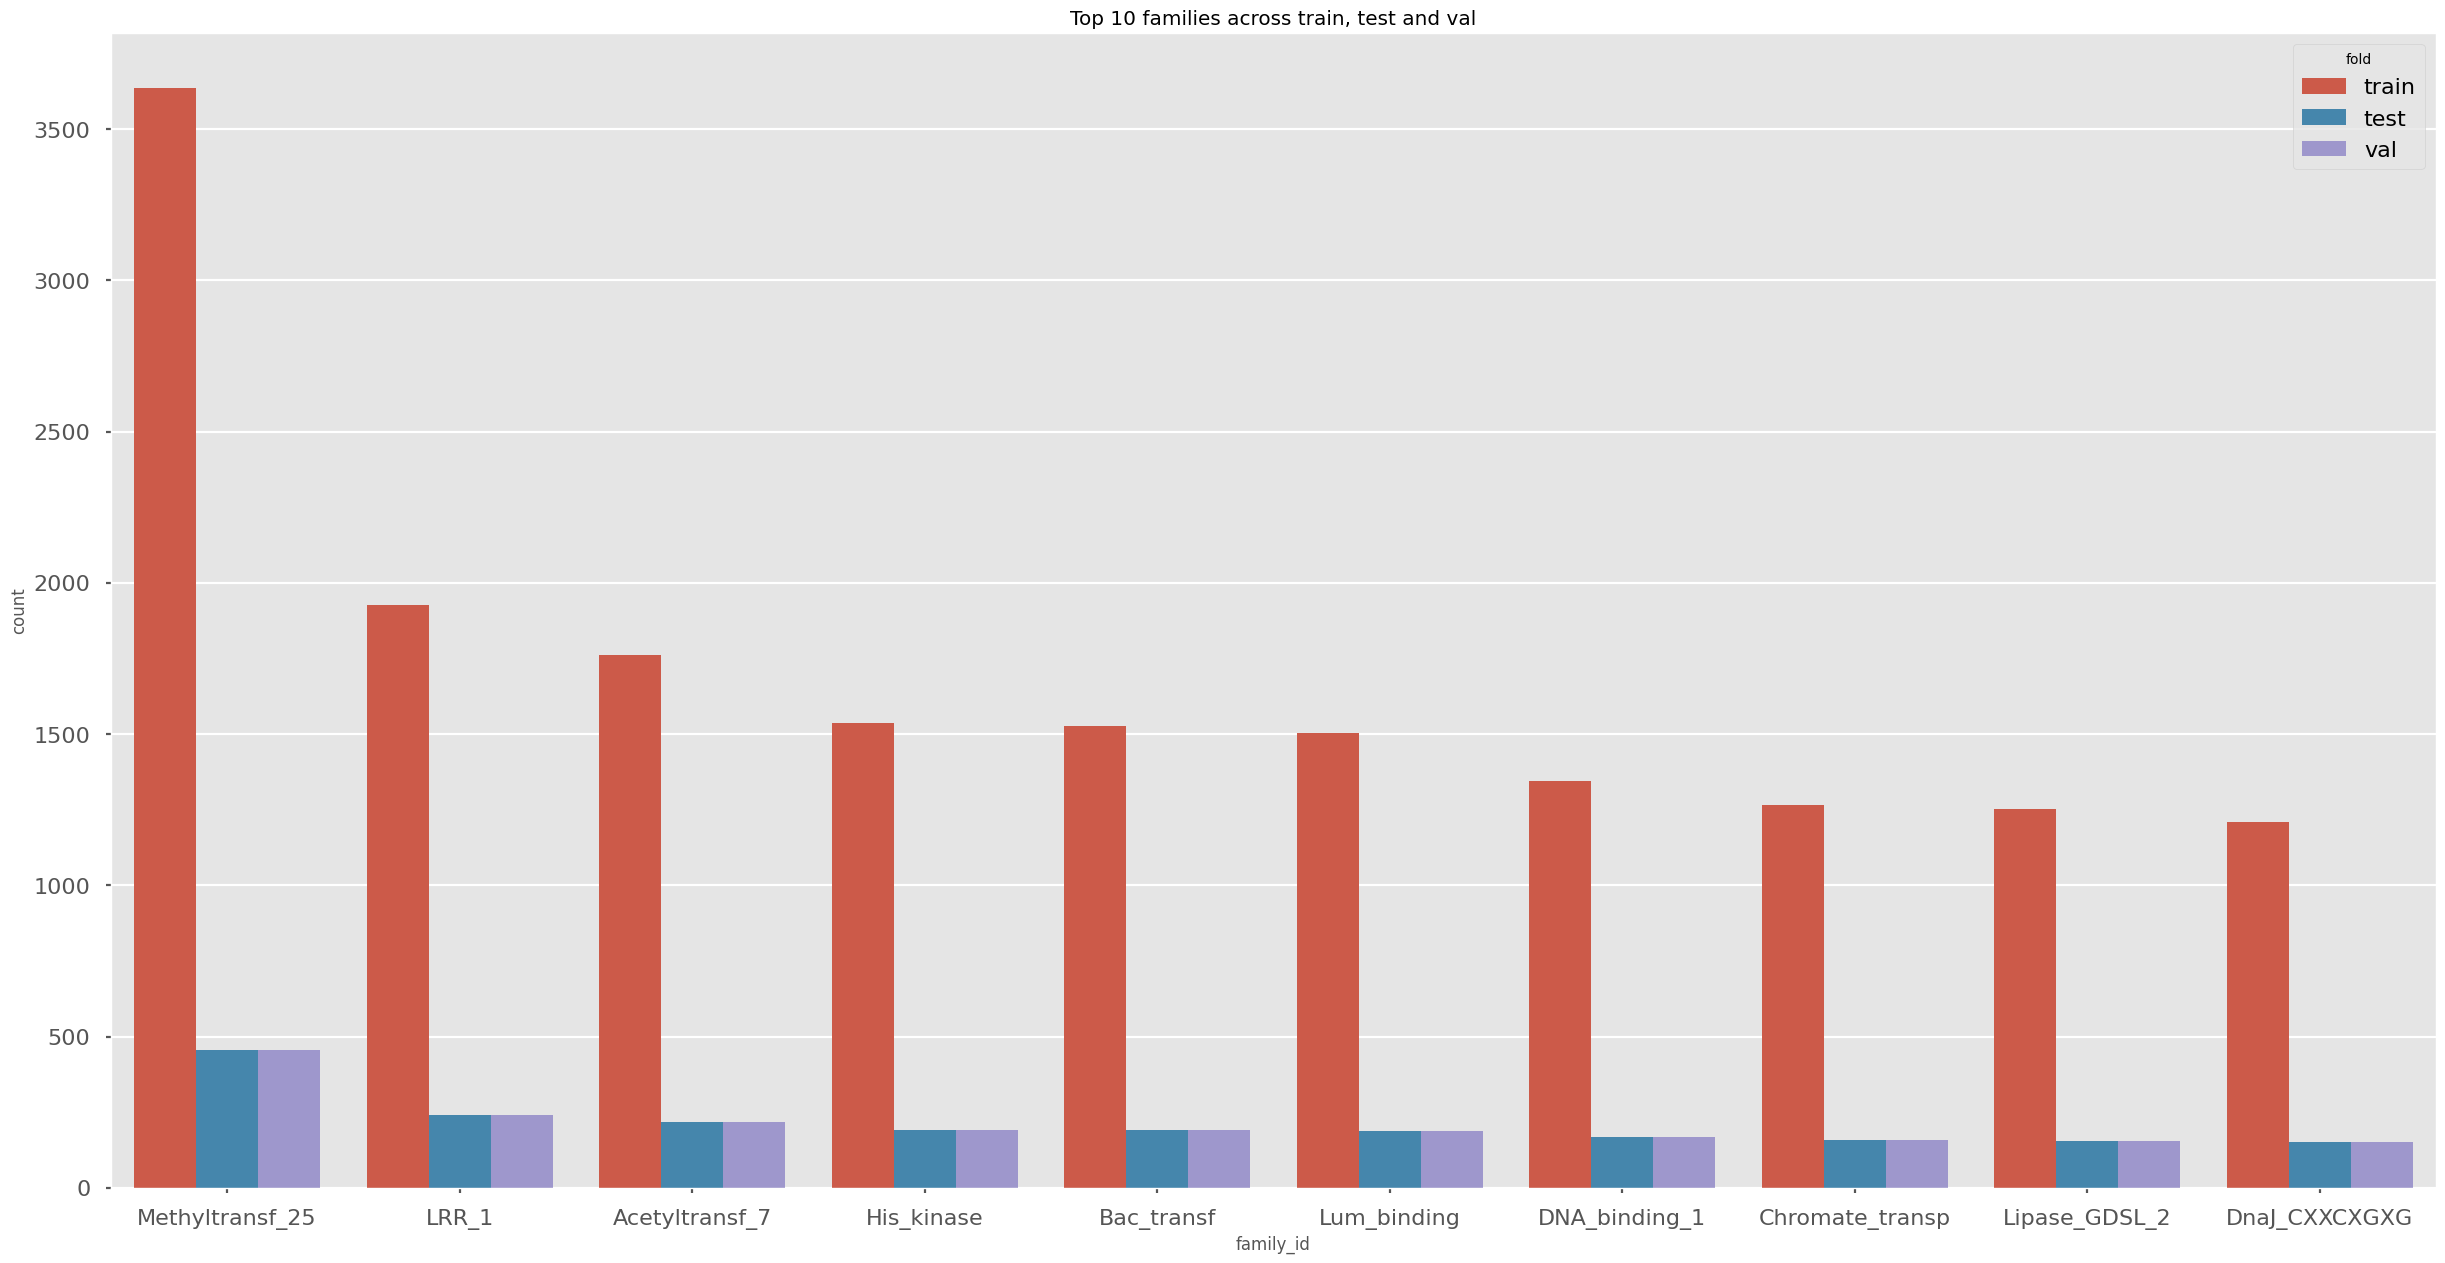

In [6]:
explorer.family_summary_plots()

Hence we are predicting a problem with thousands of classes, with low frequency. There is an imbalance, but it's not of the scale of a majority class that dominates e.g. something like fraud.

One point to think about would be limiting the data to contain only the top N classes to avoid spurious predictions.

For example, at here: https://www.kaggle.com/code/yassermhbh/pfam-ml-part1 
This user only considers classes with more than 100 occurences, leading to 52 classes.

Instead of doing this. which implicitly rescopes the problem - I have instead opted to consider this at the modelling stage but have no impact on my folds. This is so that the accuracy results would actually reflect those seen in a live system. 

My Protein knowledge is relatively limited, but one idea could be to group families into a larger "grouping", an example of this is mentioned by defining protein clans here:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1347511/

I wasn't too sure if this would be adequate, so I kept the families as they are with the thousands of classes - with the point that this makes the problem quite challenging.


In [7]:
explorer.print_family_imbalance_details()

Methyltransf_25   0.003
LRR_1             0.002
Acetyltransf_7    0.002
His_kinase        0.001
Bac_transf        0.001
Name: family_id, dtype: float64
The top 10 family IDs represent 1.56pct of train
The top 10 family IDs represent 1.68pct of test


One thing I noticed looking at the data is that there were duplicate sequences, and this is due to the below where the same sequence may be tagged under different sequence names. 

Upon further investigation, this is a minor issue but worth being aware of in case of any joins/issues with these families. I'd also like to know why this might happen before de-duping these records.

In [8]:
explorer.multiple_records_per_sequence()

There are 233 unique sequences, that have multiple family_ids 
There are 659 rows in total that have multiple family ids 

Here's an example:
                                               sequence         sequence_name
4713  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q75IE4_ORYSJ/406-474
709   GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q2QSL1_ORYSJ/406-474
6381  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q84ME8_ORYSJ/406-474
2318  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q2RAX6_ORYSJ/601-669
9685  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q2QMW4_ORYSJ/891-959





## Sequence length 

A key factor in the dataset is the sequence length of each input sequence. This will be an important consideration for compute time and performance, as we may need to truncate the sequence lengths.

* We can see the Train, Test and Val broadly have similar distributions on the sequence length
* Sequence lengths 95 perentile is 380, hence if we need to truncate sequences - it will be impacting few if above this number



Sequence length percentiles: 
count   1086741.000
mean        155.380
std         120.123
min           4.000
5%           40.000
10%          52.000
50%         119.000
90%         308.000
95%         386.000
max        2037.000
Name: sequence_length, dtype: float64





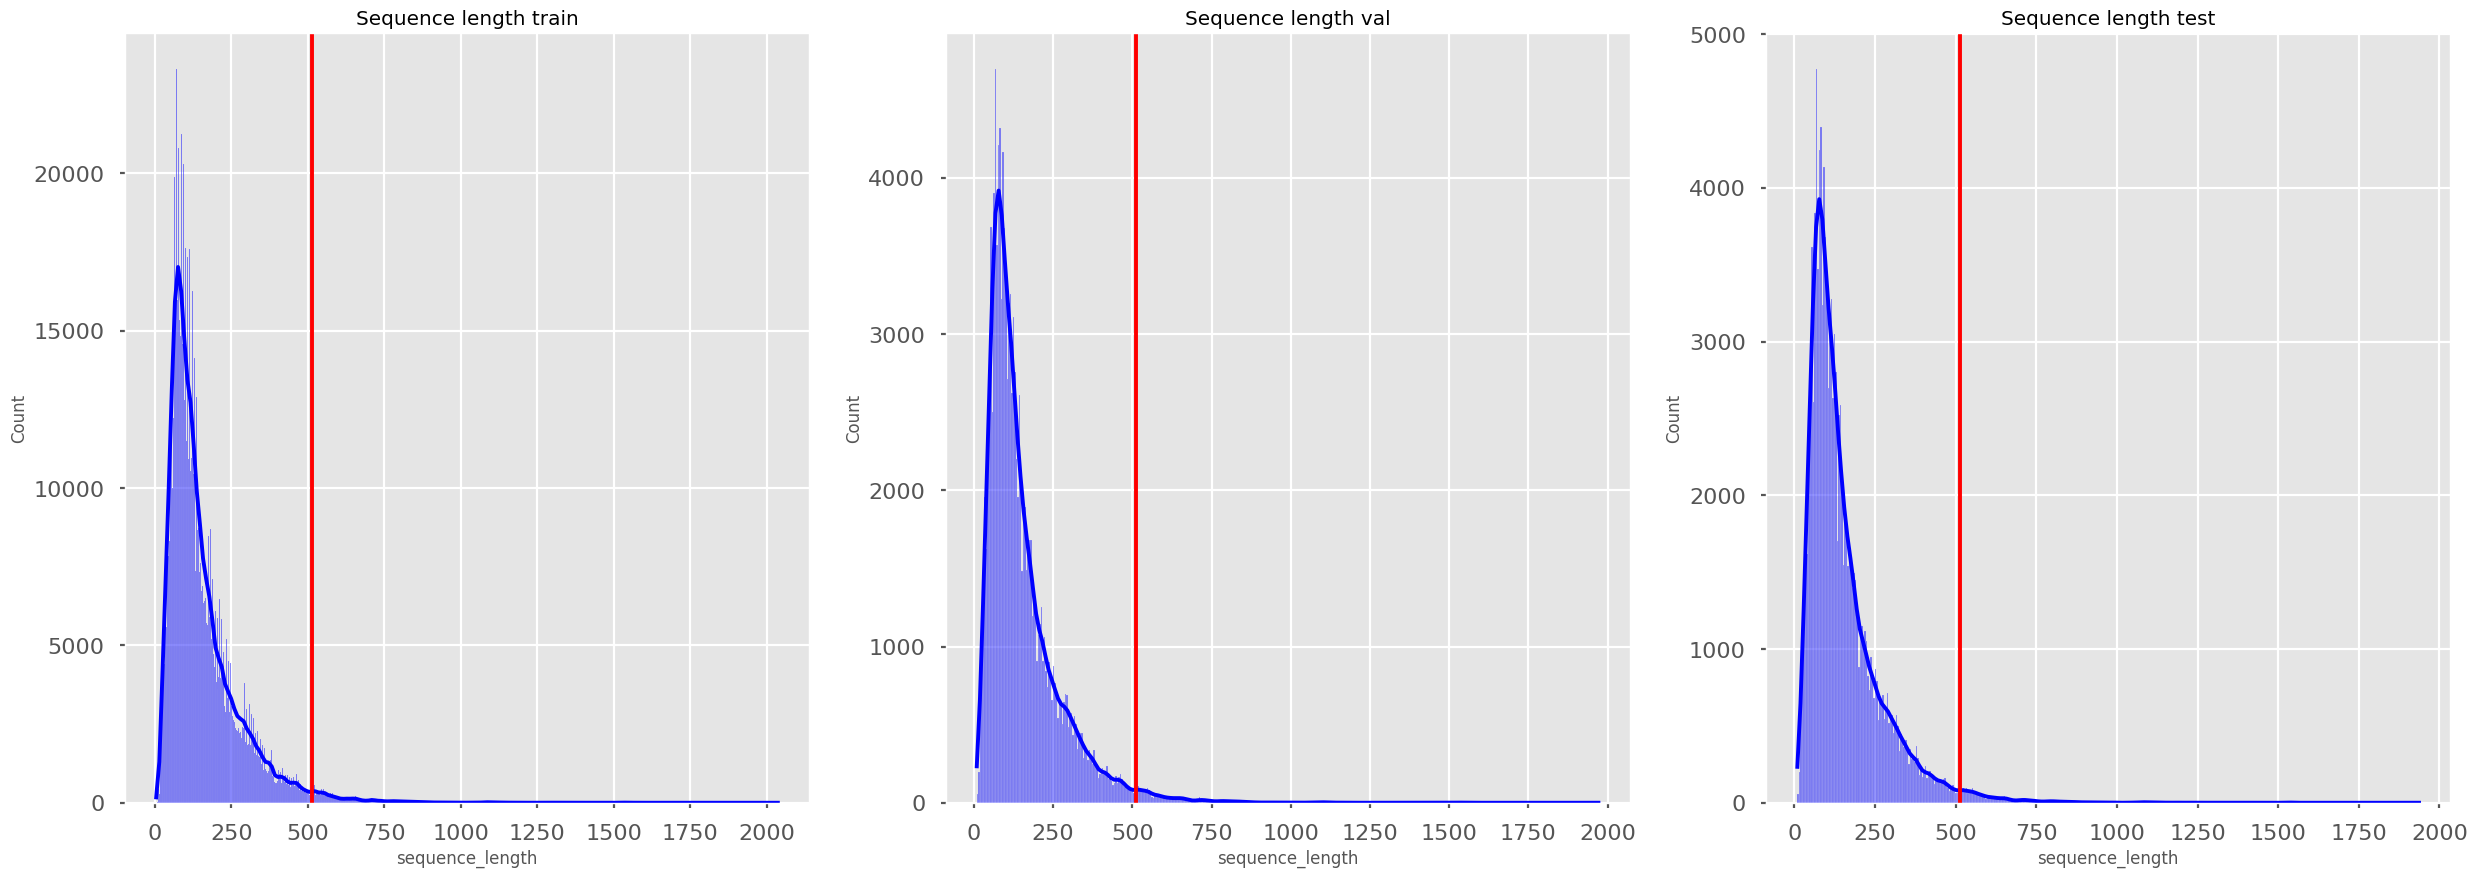

In [9]:
explorer.print_sequence_length_info()

# Major families sequence length and presence of letters

One immediate takeaway is that the major families are all relatively low in length, and there appears to be a relatively clear relationship between sequence length and family ID. Making it a likely very good indicator for modelling.

There are exceptions with Lipase_GDSL_2 being relatively spread out. 

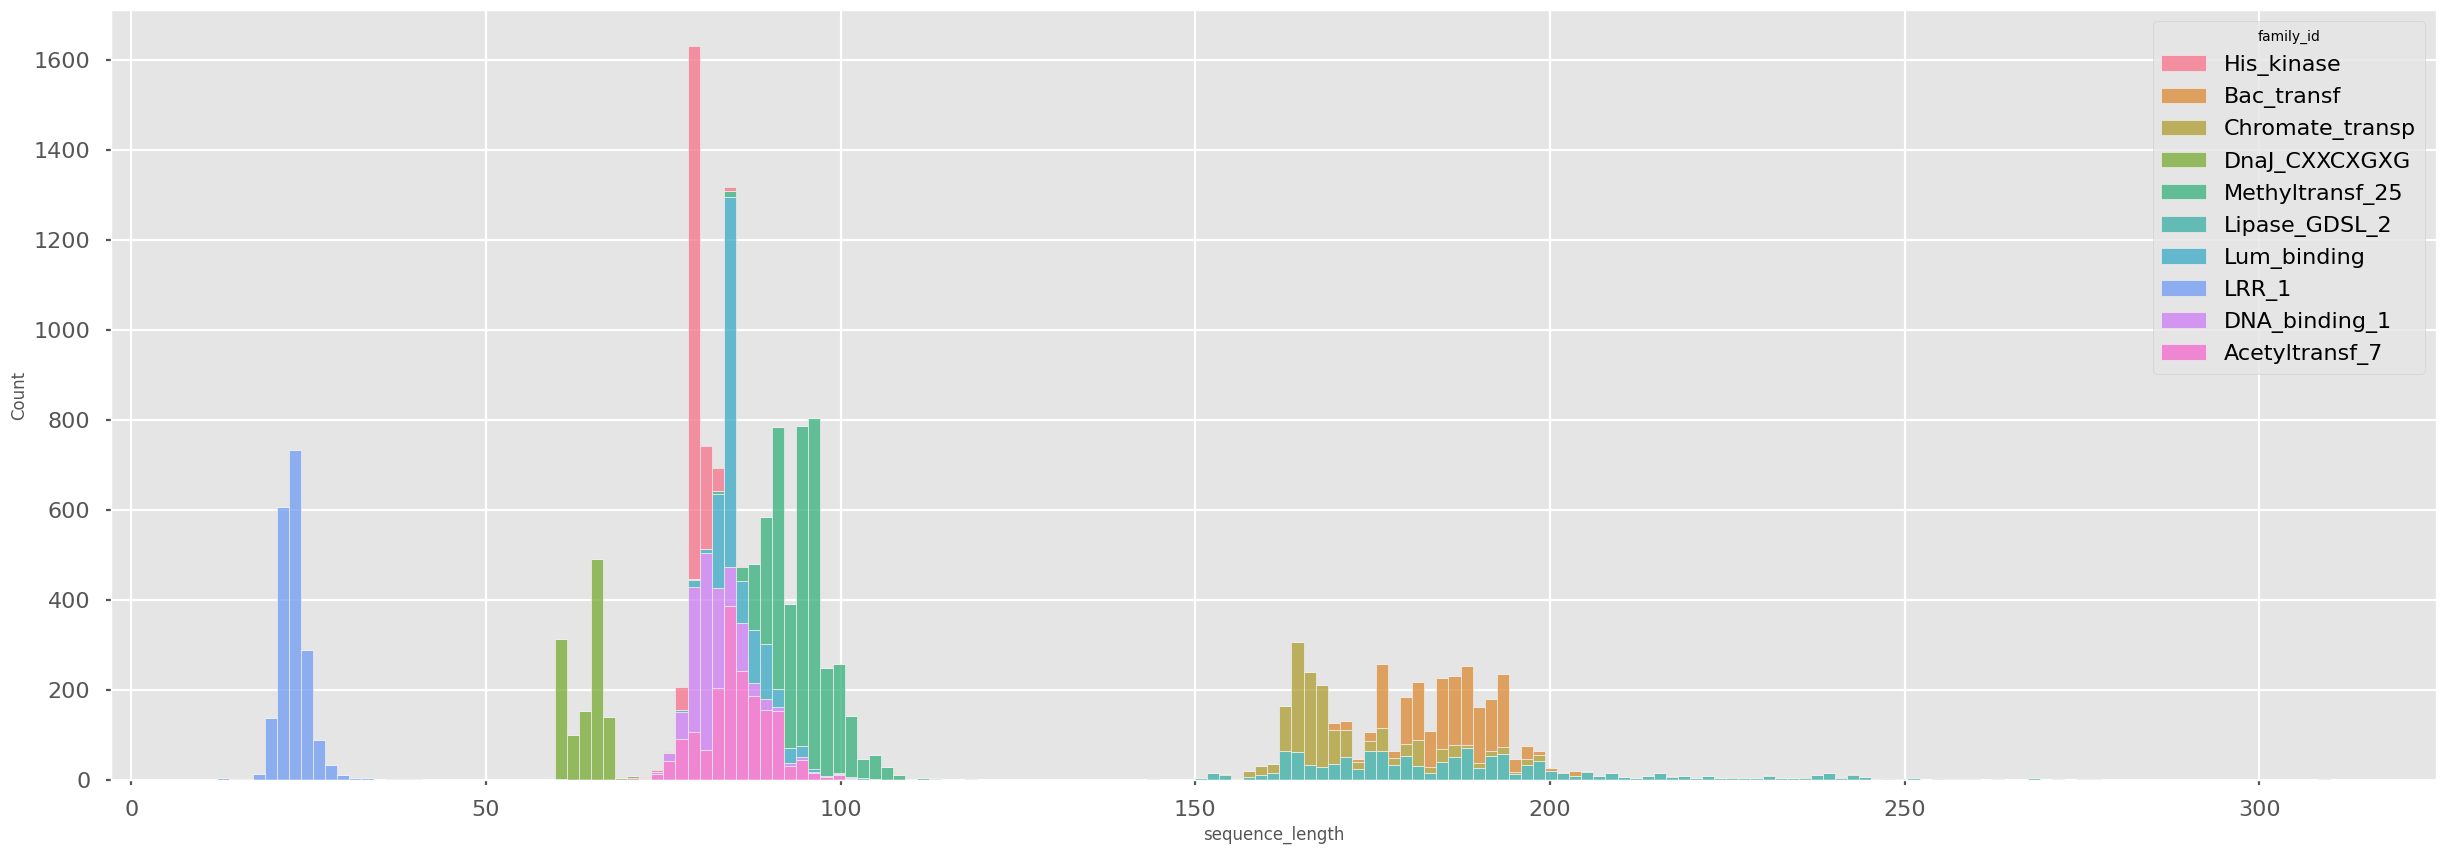

In [10]:
explorer.plot_major_families()

# Longest sequences

I then wanted to take a look at larger chains to understand how they might be impacted from truncation.

* We can see the phosphorylase group would be significantly impacted by truncating the sequence, along with FHIPEP - worth bearing this in mind if they get significantly misclassified with truncating sequence length.


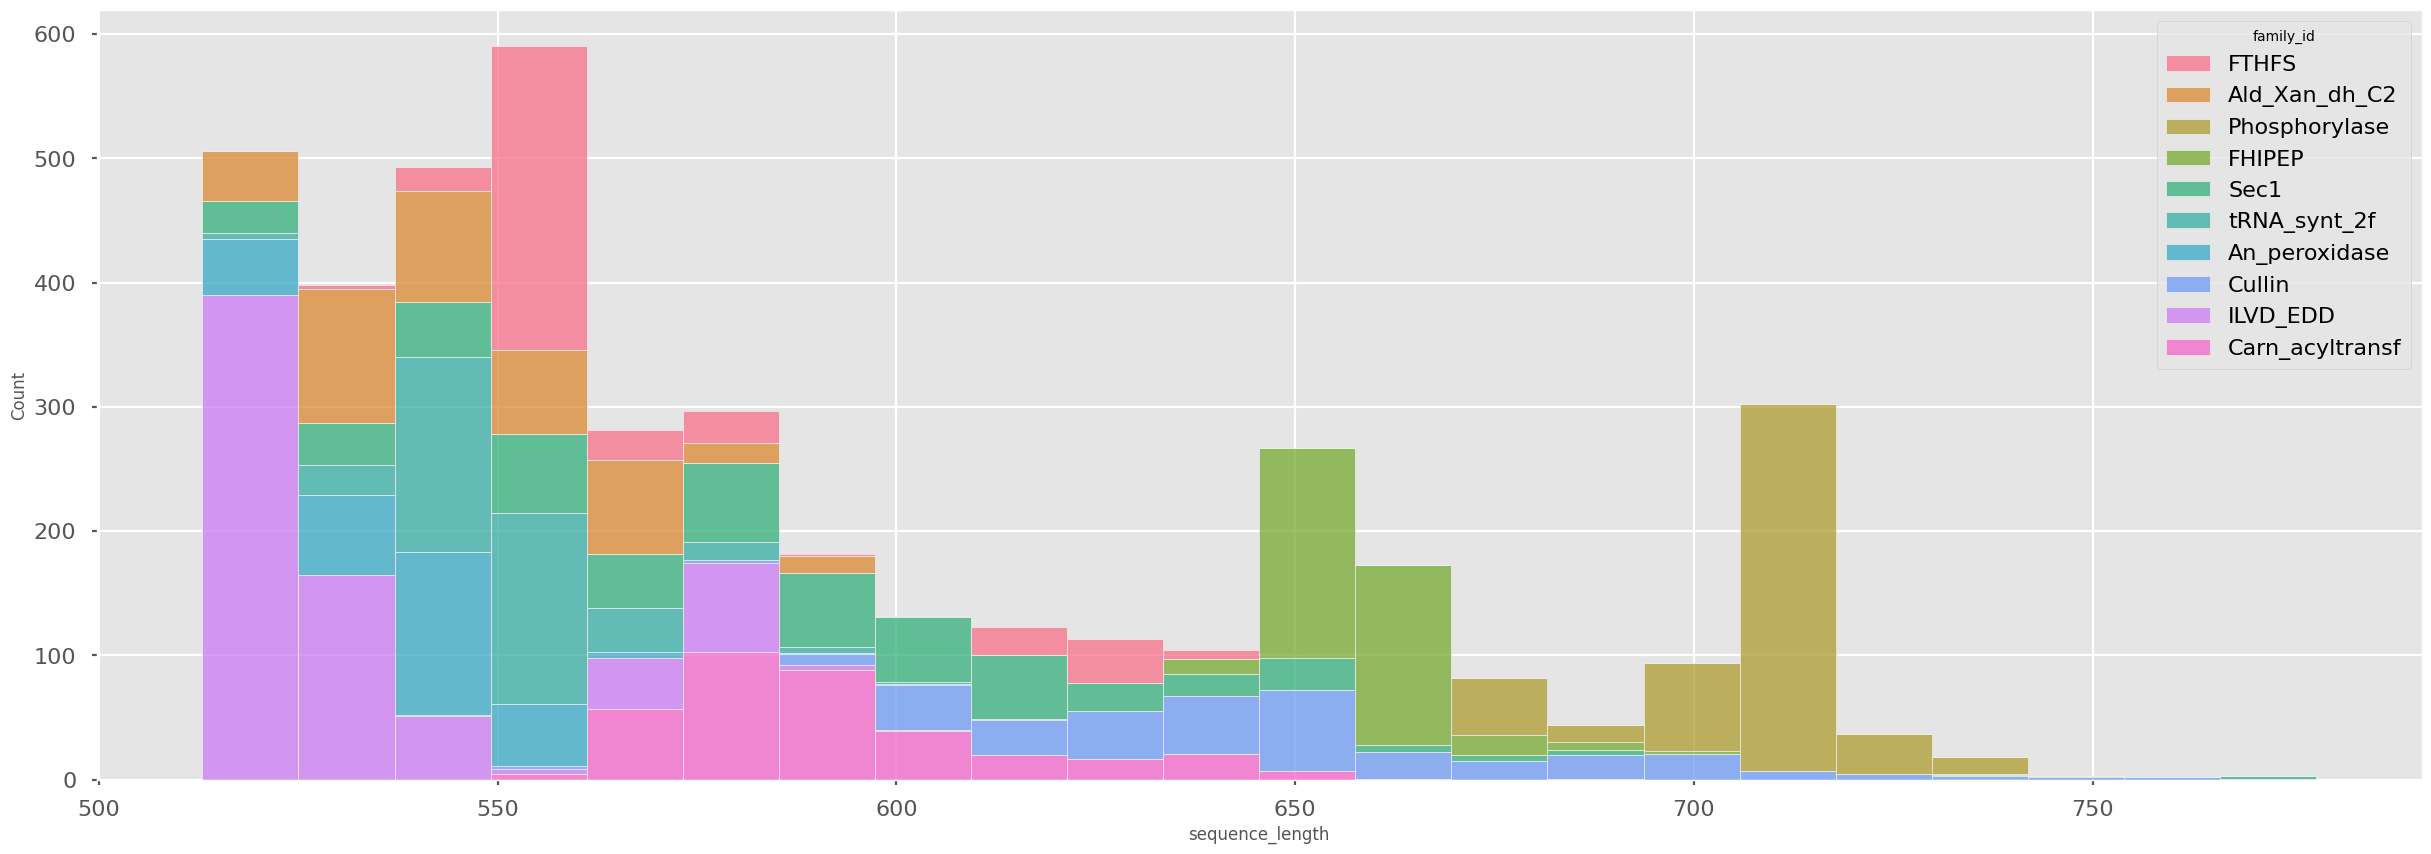

In [11]:
explorer.plot_major_families_above_threshold(length_cutoff=512)

# Amino Acids

One final point to understand was the amino acids composing of the chains. I have saved a text file containing all the acids.

In [12]:
with open("acids.txt") as f:
    acids = list(f.read())
    
rare_acids = ['X', 'U', 'B', 'O','Z']

## Rare acids

An example 

The globins are a superfamily of heme-containing globular proteins, involved in binding and/or transporting oxygen. but not all globins contain Zs for example. 

It's worth being aware of the rare acids, but it appears like they don't one to one certain families.

In [13]:
train_df[train_df['sequence'].apply(lambda x: 'Z' in list(set(x)))]

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
518,Globin,HBB_LITCT/1-105,PF00042.22,GGSDVSAFLAK.V........DKRAVGGEALARLLIVYPWTQRYFS...,GGSDVSAFLAKVDKRAVGGEALARLLIVYPWTQRYFSTFGNLGSAD...,105
712,Globin,HBBN_AMMLE/2-106,PF00042.22,BKALITGFWSK.V........KVBZVGAZALGRLLVVYPWTZRFFZ...,BKALITGFWSKVKVBZVGAZALGRLLVVYPWTZRFFZHFGBLSSAB...,105


In [14]:
train_df[train_df['sequence'].apply(lambda x: 'O' in list(set(x)))].head(5)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
9720,Cas_Cas1,M9SDX5_METAX/18-281,PF01867.16,.....DGEKVSFRNDNLVVTD......ADGE..................,DGEKVSFRNDNLVVTDADGEIVHQSTCYRIFALFIVGHITITSGII...,264
10851,DUF4422,M9SCW0_METAX/332-575,PF14393.6,OIFISCHKDTE...YV..KN.DIFKPIQVGTALS...............,OIFISCHKDTEYVKNDIFKPIQVGTALSGKKLDMLHDDEGENISFK...,244
5651,DUF531,M9SFE7_METAX/11-182,PF04407.12,RVTIGIYNAYDPKTFREPHRRIIARAGDLAMAFNMNLALFGFPIPE...,RVTIGIYNAYDPKTFREPHRRIIARAGDLAMAFNMNLALFGFPIPE...,172


In [15]:
train_df[train_df['sequence'].apply(lambda x: 'B' in list(set(x)))].head(5)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
518,Globin,HBB_LITCT/1-105,PF00042.22,GGSDVSAFLAK.V........DKRAVGGEALARLLIVYPWTQRYFS...,GGSDVSAFLAKVDKRAVGGEALARLLIVYPWTQRYFSTFGNLGSAD...,105
2198,Kunitz_BPTI,IBPC_BOVIN/7-59,PF00014.23,LCQLPQ.ARG..P.CK...A......AL...LRYFYN....STSNA...,LCQLPQARGPCKAALLRYFYNSTSNACEPFTYGGCQGNNBNFETTE...,53
3126,gag_pre-integrs,A5B8R6_VITVI/39-107,PF13976.6,GLYHL..ES..........S....Q.K...T.S...........N....,GLYHLESSQKTSNNLSXSFLSSSNKDTIWLYHLRLGHPSFRVLKVX...,69
4384,gag_pre-integrs,A5AIR1_VITVI/152-227,PF13976.6,KLYKL..NIKAT....NGNE....T.L...H.S...........S....,KLYKLNIKATNGNETLHSSNYGIKRKLINENSSMLWHRRLDHISNQ...,76
1531,YcaO,Y1265_HAEIN/60-392,PF02624.16,NGKGA.SKKAALASALGEYFERL..S........TN......YFFA...,NGKGASKKAALASALGEYFERLSTNYFFADFYLGQEIANSDFVHYP...,333


# 2 - Method Explanation

## Embedders Background

I focused on looking at generating models using a combination of a simple feature extractor and pretrained language models. 

Reading this pre-print as a helpful reference for the environment: "An Analysis of Protein Language Model Embeddings for Fold Prediction" [https://www.biorxiv.org/content/10.1101/2022.02.07.479394v1.full], some key takeaways from me:
* ESM-1B, ESM-MSA, ProtBERT, Prott5, UniRep and Seqvec are major models mentioned.
* They found strong performance from ProtBERT, prott5 and the ESM models. 
* It is also worth noting that since that paper ESM have released the esm-2 models.

I used the bio-transformers library developed by your company, and forked a copy with key modules. This was partially in case of needing to adjust the code for esm2 (which I didn't have time for) and also for dependancy management, the environment I have created uses some components of bio-transformers but not all.  

If I had time, I would of liked to extend it to include esm-2. Despite adjusting the utils/constants, it still failed. So would take more time to investigate.

Other models mentioned in this space: 
* ProtCNN from original release of dataset - https://storage.googleapis.com/pub-tools-public-publication-data/pdf/d2bf7f5a486fd3b8e2f29339660a0b39f50d21b4.pdf

Considerations in performance:
* I am using a very low performance laptop, some models may have millions/billions of parameter

Why use different embedders and not just one?
* Different training programmes for the models may capture different relationships in the dimensions of the embeddings. E.g. if they trained their model using different masking techniques to capture different parts of the structure. Hence combining these may capture more properties of the domain.
* For example ESM models use the Roberta architecture, compared to BERT. Difference is removal of next sentences prediction problem and longer sequences.

## Embedder 

This class will take the sample sizes we want for train/test/val, load the data and embed the input sequences. Outputting the files into /data/embeddings/EMBEDDER_NAME/ + FOLD_NAME.csv

Below I have created a transformer class, if this were a real process this would typically be batch ETL jobs. For example, esm1, protbert and other embedders could run at the same time using remote instances. The intention of this wrapper is to take in:
* Sequences: [AZBAZ....] -> Pandas DataFrames containing target, sequence, and a set of embeddings/numbers to describe that. 
* Because this is a take-home I have kept the processing within the same notebook.

Ways to extend this class:
* More LMs - e.g. esm2, omegafold, prott5 etc.
* More simple encoders - presence of certain subchains 
* Ideal embedders - further investigation to understand if we could get secondary structure information, even if it's predicted. E.g. presence of alpha-helix 
* Optimize smaller components: Filetypes -> parquet/ parallel files in remote storage

* Note the sample sizes are small because of limited compute, this will have a significant impact on performance as there are less rows than class labels! I would use stratified sampling if the sample_size > n_classes.

Time taken for (5000, 1000, 1000) on limited compute:
* esm1: 3 hours on CPU 
* pct_embedder: fast
* protbert/ protbert_bfd: 10 hours

** Note I would select multiple generations of models, unless they were computationally too expensive and use the feature selection at the modelling to decide what was important.

! Please reduce sample size/ comment out protbert dependant on time.

In [17]:
transformer = p.Embedder(train_size=5000, val_size=1000, test_size=1000, num_gpus=num_gpus, raw_data_path=raw_data_path)

embeddings_unloaded = ['pct_embedder', 
             'esm1_t6_43M_UR50S', 
             #'protbert' <<- only if enough resource
             ]

for embedder in embeddings_unloaded:
    transformer.embed_and_unload(embedder)
    

Using percentage embedder
Using bio-transformers library for: esm1_t6_43M_UR50S


## Model Training

Here, we want to take in the output of the embedder transformer and using the embedded features, the train model class is responsible for the classifier applied to the various features.

We assume the embedders have ran over a long period and unloaded to the paths /data/embeddings/EMBEDDER_NAME/ + FOLD_NAME.csv

The general libraries that perform pretty well for tabular problems are lightgbm and autogluon. Since we have time on a GPU, I have opted to use autogluon, which implicitly uses lightgbm. I usually use lightgbm when in a bit of a rush.

Another architecture could be to add another layer to the existing models, which I would also like to investigate.

Below is an outline of the approach:


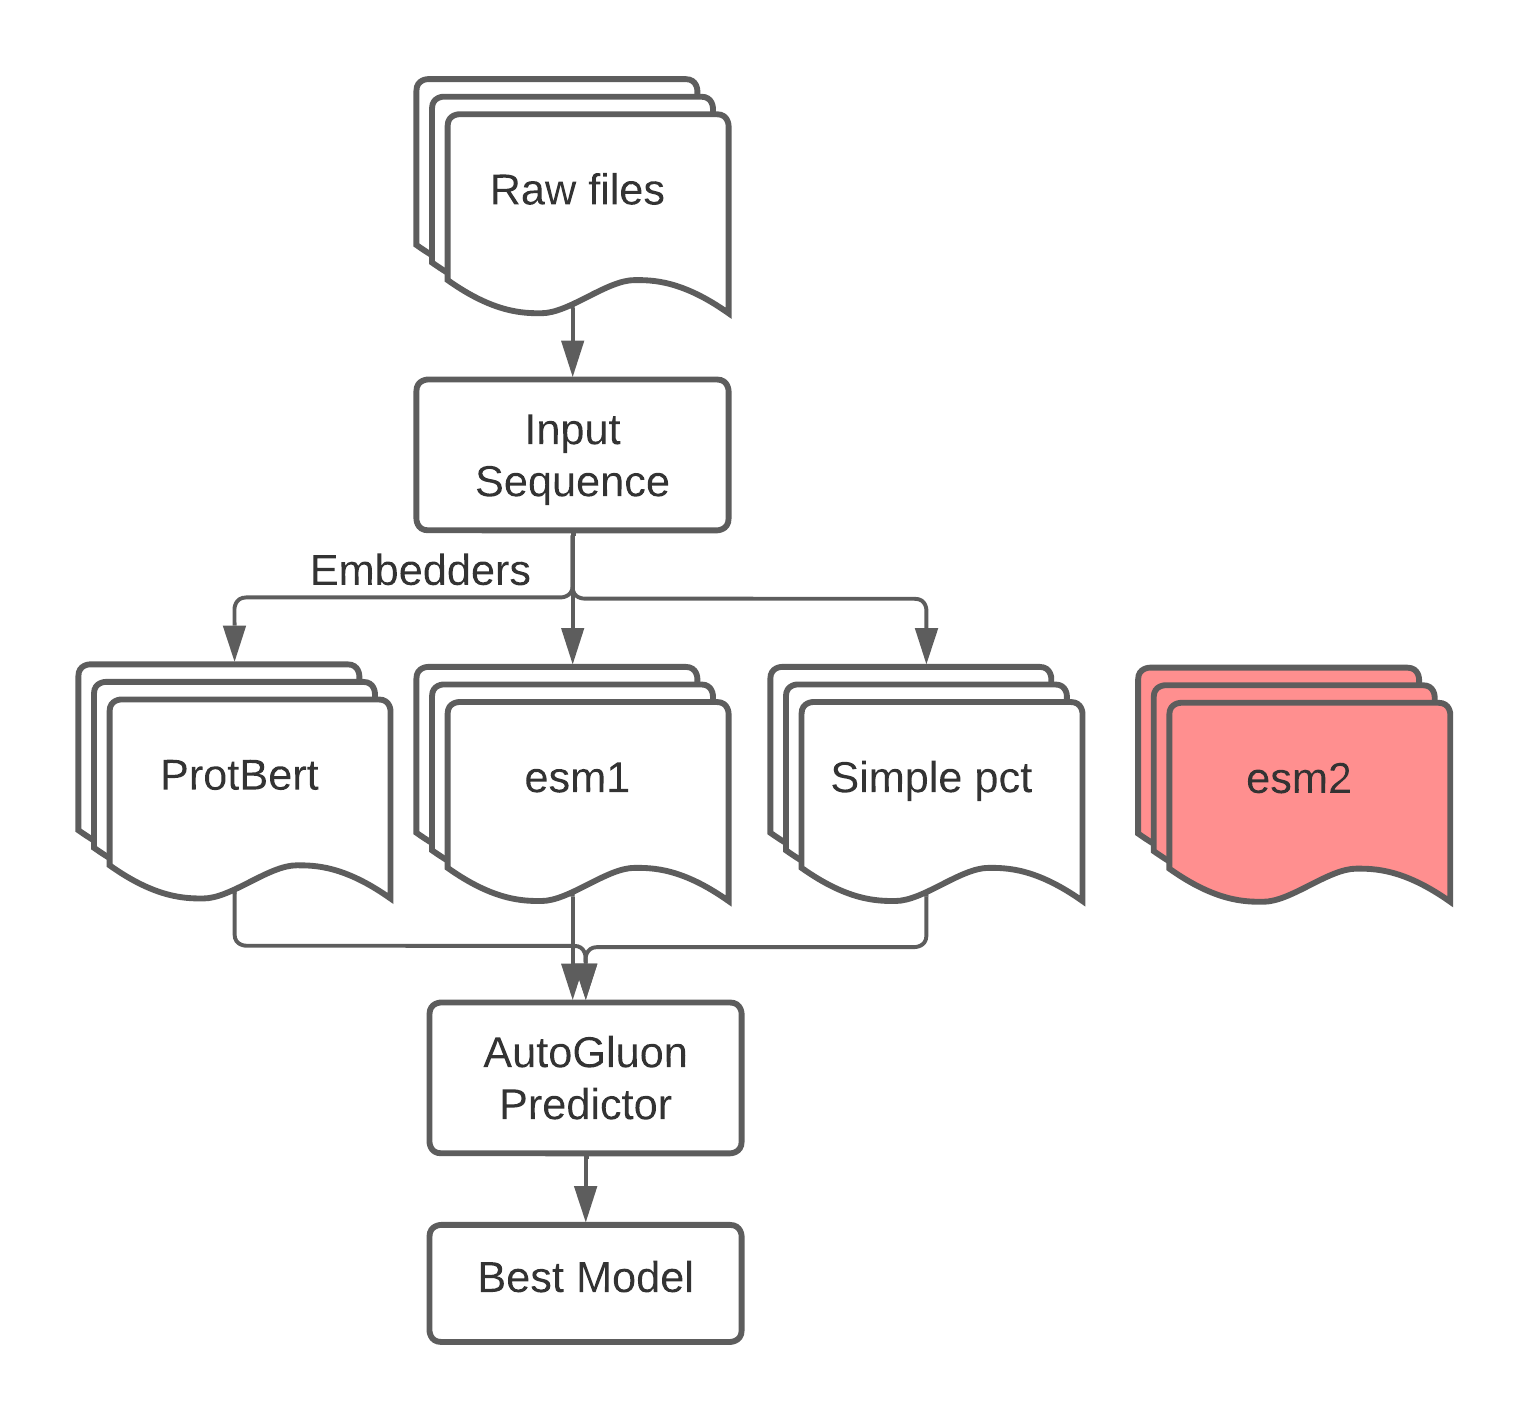

In [18]:
Image(filename='images/pfam.png', width=500, height=500) 

Modelling considerations - that are supported by autogluon:
* GPU enabled: By enabling GPU can use strong parallelization on base models like LightGBM.
* label count threshold: We can set a threshold of counts of families, which may improve performance/speed.
* eval metric: I have selected f1 weighted metric, since we have some classes with much higher frequency than others. I have opted for weighted f1 vs macro f1, to provide weighting to larger classes.

The eval metric is something I would adjust dependant on the use case, for example - we might want a classifier that performs well on sequences that have low class frequency. This might happen, if, say they are relatively new families. Equally, it's likely that our classifier will do better on major families.

We might have a industry specific metric - for example if misclassifying a kinase was much more costly than a deacylase.

* Note I have kept the label_count_threshold as 1, because our sample already has less rows than classes - hence any more filtering will just eliminate lots of families. In reality, I would hyperparameter tune this number.
* For benchmarking I have also created a simple dataset containing only the percentage features, this should be worse than the language based embedders.

In [26]:
import src.classifier as tm

all_features_model = tm.Classifier(list_of_embeddings_to_use=embeddings_unloaded, 
                                   num_gpus=num_gpus, 
                                   train_time_limit_seconds=60 * 10, 
                                   eval_metric='f1_weighted', 
                                   label_count_threshold=1)

reduced_features_model = tm.Classifier(list_of_embeddings_to_use=embeddings_unloaded, 
                                       num_gpus=num_gpus, 
                                       train_time_limit_seconds=60 * 5, 
                                       eval_metric='f1_weighted', 
                                       label_count_threshold=1)

dict_of_features, train_features, val_features, test_features = all_features_model.load_data()

reduced_columns = [col for col in train_features.columns if 'pct' in col or 'sequence' in col or 'family' in col]

set_of_full_features_dfs = (train_features, val_features, test_features)
set_of_reduced_features_dfs = (train_features[reduced_columns], val_features[reduced_columns], test_features[reduced_columns])

No path specified. Models will be saved in: "AutogluonModels\ag-20221125_201333\"
No path specified. Models will be saved in: "AutogluonModels\ag-20221125_201333-001\"


First let's check the embeddings using t-sne plots, for comparison I have added the less good percentage embedder and the esm - can clearly see that simply using percentages fails to capture the family id relationships in high dimensions, whereas with low data volumes esm has started to do so! 

I was able to run protbert on 1000 samples and that also looked very effective!

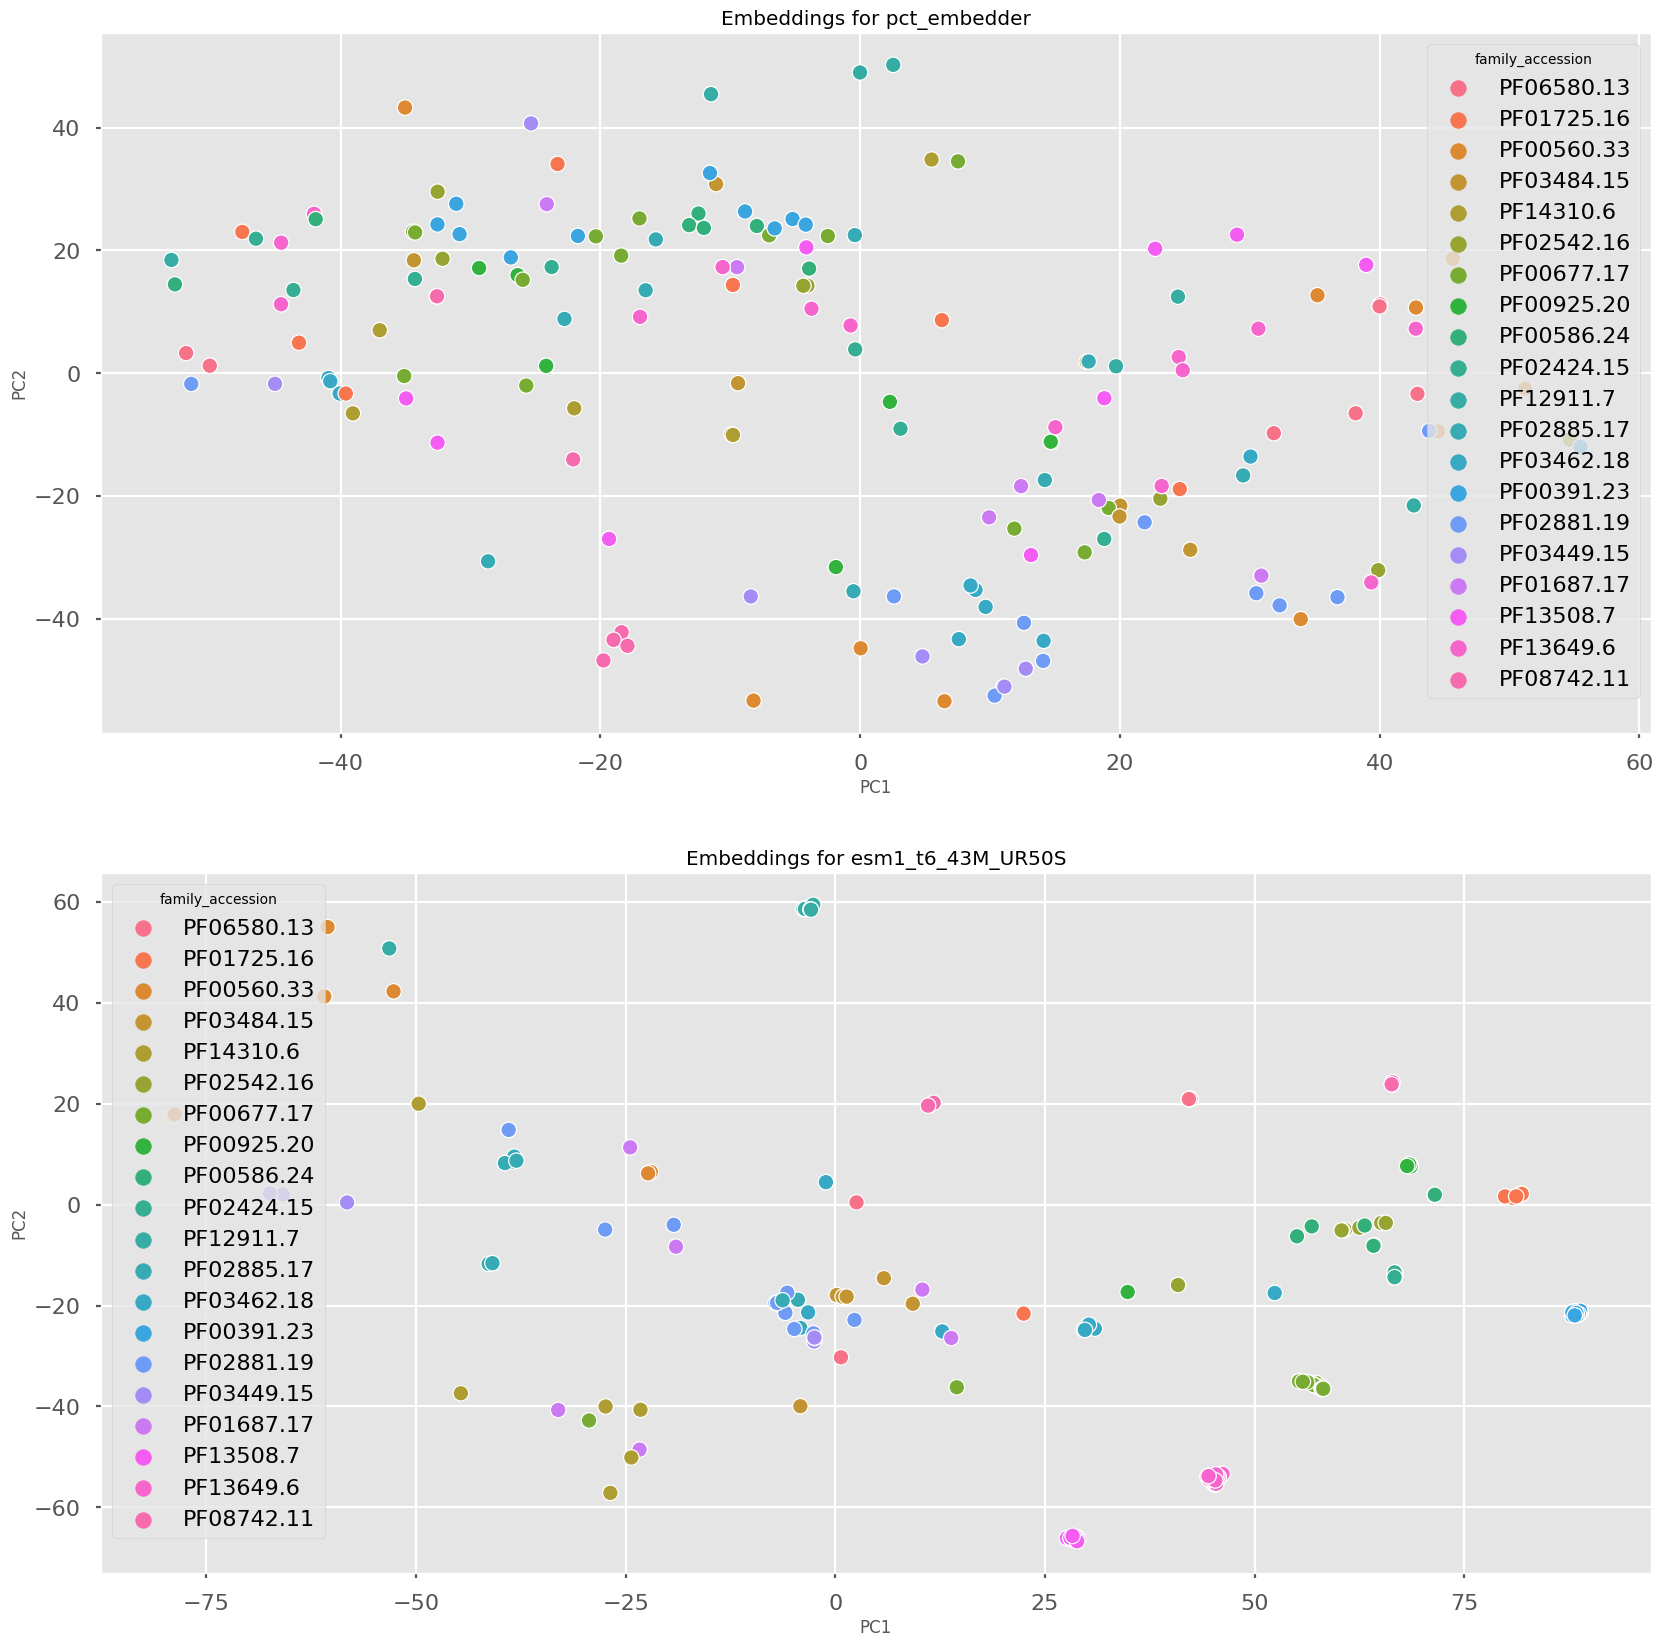

In [24]:
import src.t_sne as t_sne
t_sne.plot_all_embeddings(train_features, embeddings_unloaded, dict_of_features)

Let's train our models now!

In [27]:
all_features_model.train_model(set_of_full_features_dfs)
reduced_features_model.train_model(set_of_reduced_features_dfs, verbosity=0) 

Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels\ag-20221125_201333\"
AutoGluon Version:  0.6.0
Python Version:     3.7.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19041
Train Data Rows:    5000
Train Data Columns: 792
Tuning Data Rows:    1000
Tuning Data Columns: 792
Label Column: family_accession
Preprocessing data ...
Train Data Class Count: 3282
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    25646.02 MB
	Train Data (Original)  Memory Usage: 35.19 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting D

## Benchmarking - All features (esm + percentage embedder) vs just percentage embedder

The autogluon library has a particularly nice utility, in that it will display the results of the hyper parameter optimization in a nice bokeh supported html file. If this hasn't happened the table below is also fine.

I struggled to find any decent benchmarks on Kaggle as modellers would adjust the test sets in different ways, e.g. filtering out low frequency families. I didn't want to do this as I want it to reflect the performance in production on all samples. I suspect I would have a large amount of variance depending on my test set sampling.

You can clearly below see the power of the embeddings vs my poorly hand crafted features, with the score almost 5 times better!

In [28]:
results = all_features_model.return_results()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2      0.533          2.150   623.909                   0.008             30.362            2       True          4
1       KNeighborsDist      0.478          0.369     0.450                   0.369              0.450            1       True          2
2      NeuralNetFastAI      0.459          1.774   593.097                   1.774            593.097            1       True          3
3       KNeighborsUnif      0.319          0.332     0.293                   0.332              0.293            1       True          1
Number of models trained: 4
Types of models trained:
{'KNNModel', 'NNFastAiTabularModel', 'WeightedEnsembleModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 

In [29]:
less_good_results = reduced_features_model.return_results()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2      0.115          2.076   340.603                   0.010             38.248            2       True          4
1       KNeighborsDist      0.092          0.184     0.007                   0.184              0.007            1       True          2
2      NeuralNetFastAI      0.091          1.691   302.338                   1.691            302.338            1       True          3
3       KNeighborsUnif      0.050          0.191     0.010                   0.191              0.010            1       True          1
Number of models trained: 4
Types of models trained:
{'KNNModel', 'NNFastAiTabularModel', 'WeightedEnsembleModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 

In [30]:
best_model = all_features_model

# See performance on test

We then look at the performance of our model on the test set, and can see the leaderboard of the various autogluon models. 

We can see the accuracy is broadly around 30% and our score_test is f1_weighted is higher than 0.2.

I suspect these scores are severely impacted by not having every class in the train set, that exists.

In [32]:
test_df = set_of_full_features_dfs[2]
leaderboard, performance = best_model.evaluate_test_set(test_df.drop(['sequence'], axis=1))

NOTE: Metrics scores are always shown in ‘higher is better’ format with autogluon


In [34]:
leaderboard

,model,score_test,log_loss,pac,accuracy,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.257,-1.992,-0.015,0.271,0.533,3.987,2.150,623.909,0.140,0.008,30.362,2,True,4
1,KNeighborsDist,0.249,-7.866,-0.016,0.266,0.478,0.376,0.369,0.450,0.376,0.369,0.450,1,True,2
2,NeuralNetFastAI,0.222,-2.246,-0.015,0.237,0.459,3.471,1.774,593.097,3.471,1.774,593.097,1,True,3
3,KNeighborsUnif,0.169,-7.921,-0.016,0.189,0.319,0.361,0.332,0.293,0.361,0.332,0.293,1,True,1


In [35]:
performance

{'f1_weighted': 0.2572206571206571,
 'accuracy': 0.271,
 'balanced_accuracy': 0.4944570420760901,
 'mcc': 0.2708666380520164}

To gain more comfort, I compared the model to a random predictor using the top 10 classes from train by frequency.

Note this also has very performance, as you would expect - as it's a very tricky problem!

In [37]:
import src.naive_model as nm
random_guesser = nm.NaiveModel()
random_guesser.naive_model_accuracy(train_df, test_df)

Accuracy of Naive method 0.003


Final comments:
* I fully expect my model to be significantly below the benchmark of an actual production model - notably due to seeing a low number of labels. At 1000 samples I was getting 0.11 accuracy, and with 5000 its 0.27.
* However I hope this method as an approach is the right direction and an indication of the kind of method I would want to explore.
* GPUs are essential for this kind of language modelling.

Next steps:
* Including esm-2 as a next embedder, due to the noted improvements in performance and inference speed.
* I would want to improve the exception handling on things like file not found errors, saving of local objects to file storage etc.
* Logging: I would want a centralised logger, with the various packages (bio-transformers, transformers, etc writing to a standard file)
* Compare to Prot-CNN

